In [14]:
from Bio import motifs
from Bio.Seq import Seq
import logomaker

import pandas as pd
import numpy as np
import time
import itertools
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from scipy.stats import kruskal

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.model_selection import train_test_split
from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [2]:
# Read training data
BA_df = pd.read_csv('./Data/Data_HLA.csv', index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9].reset_index(drop=True)

# Read count df
count_df = pd.read_csv('./Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 6 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

In [4]:
# generate PWM  for MHCmotif atlas data
mhcmotifatlas_df = pd.read_csv('./results/PWM/PWM_mhcmotifatlas/data_classI_MS_Peptides_all_peptides.txt', sep='\t')
mhcmotifatlas_df['length'] = [len(i) for i in mhcmotifatlas_df['Peptide']]
mhcmotifatlas_df = mhcmotifatlas_df[mhcmotifatlas_df['length']==9]
mhcmotifatlas_df['allele'] = ['HLA-'+i[0]+"*"+i[1:3]+":"+i[3:] for i in mhcmotifatlas_df['Allele']]

for allele in tqdm(allele_ls):
    if allele in mhcmotifatlas_df['allele'].unique():
        tmp_df = mhcmotifatlas_df[mhcmotifatlas_df['allele']==allele]
        sequences = tmp_df['Peptide'].to_list()
        pwm = get_allele_pwm(sequences)
        pd.DataFrame(pwm).to_csv('./results/PWM/PWM_mhcmotifatlas/'+allele+'_mhcmotifatlas_PWM.csv')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:12<00:00,  7.99it/s]


In [3]:
# generate PWM  for training data
for allele in tqdm(allele_ls):
    tmp_df = BA_df[BA_df['allele']==allele]
    tmp_df = tmp_df[tmp_df['y']==1]
    sequences = tmp_df['peptide'].to_list()
    pwm = get_allele_pwm(sequences)
    pd.DataFrame(pwm).to_csv('./results/PWM/PWM_training_data/'+allele+'_training_data_PWM.csv')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:02<00:00, 38.08it/s]


In [8]:
# generate PWM  for predicted data
_ = RuleClassifier()

#### load model
with open("./model/MHCRuleHydroPep.pkl", "rb") as f:
    hydropep = pickle.load(f)
f.close()
    
for allele in tqdm(allele_ls):
    tmp_df = BA_df[BA_df['allele']==allele].reset_index(drop=True)
    X_ = get_vector_representation(tmp_df['peptide'].to_list())
    
    prediction = hydropep.predict(allele, X_)
    
    binders_idx = [idx for idx,i in enumerate(prediction) if i==1]
    
    sequences = tmp_df['peptide'].iloc[binders_idx].to_list()
    
    if len(sequences)>0:  
        pwm = get_allele_pwm(sequences)
        pd.DataFrame(pwm).to_csv('./results/PWM/PWM_predicted_data/'+allele+'_predicted_data_PWM.csv')

    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:29<00:00,  3.39it/s]


KruskalResult(statistic=1.1411503195332102, pvalue=0.2854093903931296)


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


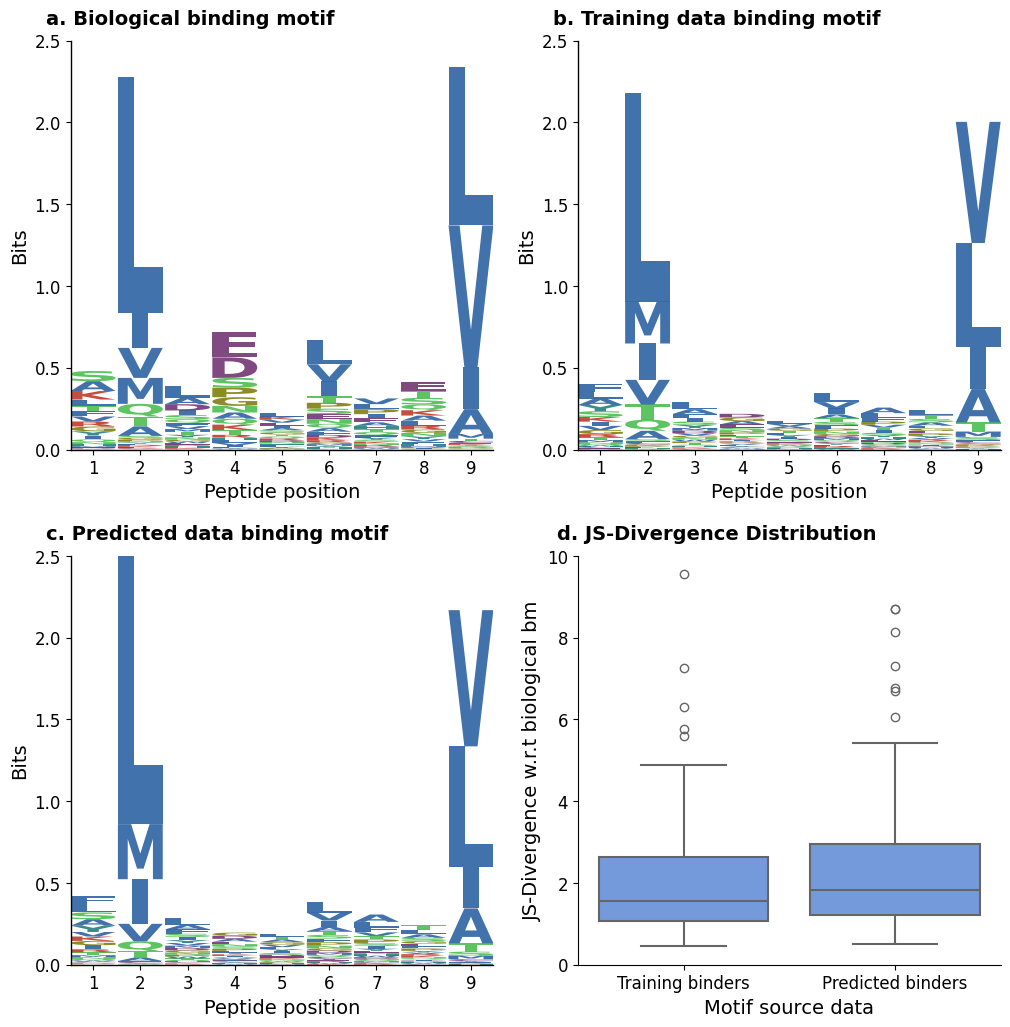

In [13]:
dpi = 600
fontsize = 14

fig, axs = plt.subplots(2,2, figsize=(12,12))

# gs = GridSpec(2, 2, height_ratios=[0.8, 0.8], width_ratios=[2, 1])

# # Create subplots within this grid
# ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
# ax2 = fig.add_subplot(gs[0, 1])  # First row, second column
# ax3 = fig.add_subplot(gs[1, 0])  # Second row, first column
# ax4 = fig.add_subplot(gs[1, 1])  # Second row, second column

################# Trained peptides
# pwm_df = pd.read_csv('./results/PWM/PWM_A0201_1.csv',index_col=0).T.reset_index(drop=True)

# mhcmotifatlas_df = pd.read_csv('./results/PWM/MHCMotifAtlas_A0201.csv')
# mhcmotifatlas_df['length'] = [len(i) for i in mhcmotifatlas_df['peptides'].to_list()]
# mhcmotifatlas_df = mhcmotifatlas_df[mhcmotifatlas_df['length']==9].reset_index(drop=True)

# pwm_df = pd.DataFrame(get_allele_pwm(mhcmotifatlas_df['peptides'].to_list()))

pwm_df = pd.read_csv('./results/PWM/PWM_mhcmotifatlas/HLA-A*02:01_mhcmotifatlas_PWM.csv',index_col=0)
entropy = -np.sum(pwm_df * np.log2(pwm_df + 1e-9), axis=1)

# Calculate the maximum entropy (log2(4) for DNA sequences)
max_entropy = np.log2(20)

# Calculate the information content (bits)
information_content = max_entropy - entropy
bits_df = pwm_df.multiply(information_content, axis=0)
bits_df['positions'] = [i+1 for i in range(9)]
bits_df = bits_df.set_index('positions')

logo = logomaker.Logo(bits_df, color_scheme='NajafabadiEtAl2017', 
                      ax=axs[0][0],alpha=0.85, stack_order='big_on_top')

# Customize the appearance of the logo
logo.style_spines(visible=False)  # Remove spines
logo.style_spines(spines=['left', 'bottom'], visible=True)  # Add left and bottom spines
logo.style_xticks(rotation=0, anchor=0,fontsize=fontsize-2)  # Customize x-axis tick labels
logo.ax.set_ylabel('Bits', fontsize=fontsize)
logo.ax.set_xlabel('Peptide position', fontsize=fontsize)
yticklabels = logo.ax.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)
logo.ax.set(ylim=(0,2.5))

logo.ax.text(0, 2.6, 'a. Biological binding motif', weight='bold', fontsize=fontsize)


################# Trained peptides
pwm_df = pd.read_csv('./results/PWM/PWM_training_data/HLA-A*02:01_training_data_PWM.csv',index_col=0)

entropy = -np.sum(pwm_df * np.log2(pwm_df + 1e-9), axis=1)

# Calculate the maximum entropy (log2(4) for DNA sequences)
max_entropy = np.log2(20)

# Calculate the information content (bits)
information_content = max_entropy - entropy
bits_df = pwm_df.multiply(information_content, axis=0)
bits_df['positions'] = [i+1 for i in range(9)]
bits_df = bits_df.set_index('positions')

logo = logomaker.Logo(bits_df, color_scheme='NajafabadiEtAl2017', 
                      ax=axs[0][1], alpha=0.85, stack_order='big_on_top')

# Customize the appearance of the logo
logo.style_spines(visible=False)  # Remove spines
logo.style_spines(spines=['left', 'bottom'], visible=True)  # Add left and bottom spines
logo.style_xticks(rotation=0, anchor=0,fontsize=fontsize-2)  # Customize x-axis tick labels
logo.ax.set_ylabel('Bits', fontsize=fontsize)
logo.ax.set_xlabel('Peptide position', fontsize=fontsize)
yticklabels = logo.ax.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)
logo.ax.set(ylim=(0,2.5))

logo.ax.text(0, 2.6, 'b. Training data binding motif', weight='bold', fontsize=fontsize)

################# Trained peptides
fig.subplots_adjust(hspace=0.26)
pwm_df = pd.read_csv('./results/PWM/PWM_predicted_data/HLA-A*02:01_predicted_data_PWM.csv',index_col=0)

entropy = -np.sum(pwm_df * np.log2(pwm_df + 1e-9), axis=1)

# Calculate the maximum entropy (log2(4) for DNA sequences)
max_entropy = np.log2(20)

# Calculate the information content (bits)
information_content = max_entropy - entropy
bits_df = pwm_df.multiply(information_content, axis=0)
bits_df['positions'] = [i+1 for i in range(9)]
bits_df = bits_df.set_index('positions')

logo = logomaker.Logo(bits_df, color_scheme='NajafabadiEtAl2017', ax=axs[1][0],alpha=0.85)

# Customize the appearance of the logo
logo.style_spines(visible=False)  # Remove spines
logo.style_spines(spines=['left', 'bottom'], visible=True)  # Add left and bottom spines
logo.style_xticks(rotation=0, anchor=0,fontsize=fontsize-2)  # Customize x-axis tick labels
logo.ax.set_ylabel('Bits', fontsize=fontsize)
logo.ax.set_xlabel('Peptide position', fontsize=fontsize)
yticklabels = logo.ax.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)
logo.ax.set(ylim=(0,2.5))

logo.ax.text(0, 2.6, 'c. Predicted data binding motif', weight='bold', fontsize=fontsize)


################# JS distance
JS_divergence_df = pd.DataFrame({})
JS_divergence_df['Training binders'] = pd.read_csv('./Data/diffmotif_training_data_results_calculated.csv')['V1']
JS_divergence_df['Predicted binders'] = pd.read_csv('./Data/diffmotif_predicted_data_results_calculated.csv')['V1']

print(kruskal(JS_divergence_df[JS_divergence_df['Training binders']!=100000.0]['Training binders'].dropna(),
              JS_divergence_df[JS_divergence_df['Predicted binders']!=100000.0]['Predicted binders'].dropna()))

JS_divergence_df = JS_divergence_df.melt()
JS_divergence_df = JS_divergence_df[JS_divergence_df['value']!=100000.0]

b = sns.boxplot(data=JS_divergence_df, x='variable', y='value', order=['Training binders', 'Predicted binders'],
                saturation = 0.75, linewidth=1.5, ax=axs[1][1], color='CornflowerBlue')

# Adding labels 
# Retrieve and modify existing y-axis tick labels fontsize
yticklabels = b.get_yticklabels()
for label in yticklabels:
    label.set_fontsize(fontsize-2)  # Set fontsize to 10
    
b.set_xticklabels(b.get_xticklabels(),fontsize=fontsize-2,rotation=0)

b.set(ylim=(0,10))
b.set_ylabel('JS-Divergence w.r.t biological bm', fontsize=fontsize)
b.set_xlabel('Motif source data', fontsize=fontsize)
b.text(-0.6, 10.4, 'd. JS-Divergence Distribution', weight='bold', fontsize=fontsize)

sns.despine(top=True, right=True)
fig.savefig('./figures/learned_profiles/learned_profiles.png',dpi=dpi, bbox_inches="tight")
